In [1]:
# Set up imports and libraries
# datasets at: https://www.yelp.com/dataset
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
#nltk.download('punkt')
#nltk.download('vader_lexicon')

In [2]:
# import business dataset
import pandas as pd
yelp_busn = []
r_dtypes = {"stars": np.float16, 
            "latitude": np.int32, 
            "longitude": np.int32,
           }
with open("yelpify/yelp_academic_dataset_business.json", "r", encoding='utf8') as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['is_open', 'longitude','latitude','hours'])\
                             .query("`state` == 'FL'")
        yelp_busn.append(reduced_chunk) 
    
yelp_busn = pd.concat(yelp_busn, ignore_index=True)

In [3]:
# limit review set to restaurants in FL for the time period
yelp_busn = yelp_busn[yelp_busn['categories'].str.contains('Restaurant')==True]

,business_id,name,address,city,state,postal_code,stars,review_count,attributes,categories
2,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,4.0,10,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks"
4,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,4.5,100,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","Food, Delis, Italian, Bakeries, Restaurants"
7,uI9XODGY_2_ieTE6xJ0myw,Roman Forum,10440 N Dale Mabry Hwy,Tampa,FL,33618,4.0,23,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, American (New), Italian"
8,JgpnXv_0XhV3SfbfB50nxw,Joe's Pizza,2038 N Dale Mabry Hwy,Tampa,FL,33607,4.0,35,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Pizza"
12,pJfh3Ct8iL58NZa8ta-a5w,Top Shelf Sports Lounge,3173 Cypress Ridge Blvd,Wesley Chapel,FL,33544,4.5,95,"{'BestNights': '{'monday': False, 'tuesday': F...","Burgers, Sports Bars, Bars, Lounges, Restauran..."
...,...,...,...,...,...,...,...,...,...,...
26315,Scd-rcsQCn60t1sHHFv-og,First Watch,"4045 N Tyrone Blvd, Ste 204",St. Petersburg,FL,33709,3.5,183,"{'RestaurantsPriceRange2': '2', 'OutdoorSeatin...","Cafes, Restaurants, Breakfast & Brunch, Americ..."
26320,8MzF1Tlgz0pOkxmhP5dYzA,El Cap Restaurant,3500 4th St N,St. Petersburg,FL,33704,3.5,414,"{'GoodForKids': 'True', 'BikeParking': 'True',...","American (Traditional), Burgers, Restaurants"
26322,-bZQH8yjm7ntTyGeLQwh8Q,Farmer's Kitchen Restaurant,3500 E Bay Dr,Largo,FL,33771,4.0,6,"{'RestaurantsReservations': 'True', 'Restauran...","Sandwiches, Restaurants, Diners"
26323,BIyT7Kr7tMJqlfp4oOOYQg,Copper Bell Cafe,11228 Boyette Rd,Riverview,FL,33569,3.5,49,"{'BikeParking': 'True', 'RestaurantsReservatio...","Breakfast & Brunch, Cafes, Restaurants"


In [4]:
#import the review data set
yelp_reviews = []
r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }
with open("yelpify/yelp_academic_dataset_review.json", "r", encoding='utf8') as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=1000)
        
    for chunk in reader:
        reduced_chunk = chunk.drop(columns=['review_id', 'user_id','useful','funny','cool'])\
                             .query('date >= "2022-01-01"')
        yelp_reviews.append(reduced_chunk)
        
yelp_reviews = pd.concat(yelp_reviews, ignore_index=True)
#yelp_reviews.describe #80k rows for 12/1/21; 31665  for 2022-01-01

In [5]:
keys = list(yelp_busn['business_id'].values) #business filtered to FL and restaurant
keys
yelp_busn.set_index('business_id') #dupes?
yelp_reviews.set_index('business_id')
i1 = yelp_reviews.index
i2 = yelp_busn.index
yelp_reviews_FL = yelp_reviews[i1.isin(i2)]
yelp_reviews_FL


,business_id,stars,text,date
2,Jo4ei-c-5H53IxZxAVf1jQ,5.0,Danielle did a great job! She listened and cu...,2022-01-03 03:17:03
4,9MHe5jAym2d8VhT_NbCRyw,2.0,We Ordered pork fried rice and beef chow mei ...,2022-01-06 03:59:21
7,6U0ZweWWWQUzea2rF4zKgQ,5.0,Food was good love the Cuban sandwiche \nThe p...,2022-01-10 19:54:45
8,yYpU8EWucx32OYIIHqP63A,1.0,Have called this location multiple times throu...,2022-01-11 21:07:05
12,LIoU5gBv75l1lMFaQ3wyfQ,5.0,"Excellent, stopped in for a late lunch and was...",2022-01-03 20:37:31
...,...,...,...,...
26315,EhotxJEJxpMgCJ0F82Buvg,2.0,Pretty disappointed in this place. Nice decor ...,2022-01-01 06:46:38
26320,TaYJfvjk0kLMnS-gQd28bw,2.0,Ok place with a nice crowd but servers are poo...,2022-01-06 23:38:54
26322,81dk-1nYjlJDEIG3DRZIwg,4.0,Better if they had food. Decent but not world ...,2022-01-08 20:11:06
26323,6Cs52T0ItZ5TQ5Qx-UGaMw,5.0,Great food. Great service. Two things that ...,2022-01-08 23:08:17


In [6]:
# append text length of review
yelp_reviews_FL.describe
yelp_reviews_FL['text length'] = yelp_reviews_FL['text'].apply(len)
yelp_reviews_FL.head()
yelp_reviews_FL

C:\Users\mcdc9\AppData\Local\Temp/ipykernel_6260/3368109950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yelp_reviews_FL['text length'] = yelp_reviews_FL['text'].apply(len)


,business_id,stars,text,date,text length
2,Jo4ei-c-5H53IxZxAVf1jQ,5.0,Danielle did a great job! She listened and cu...,2022-01-03 03:17:03,278
4,9MHe5jAym2d8VhT_NbCRyw,2.0,We Ordered pork fried rice and beef chow mei ...,2022-01-06 03:59:21,148
7,6U0ZweWWWQUzea2rF4zKgQ,5.0,Food was good love the Cuban sandwiche \nThe p...,2022-01-10 19:54:45,116
8,yYpU8EWucx32OYIIHqP63A,1.0,Have called this location multiple times throu...,2022-01-11 21:07:05,874
12,LIoU5gBv75l1lMFaQ3wyfQ,5.0,"Excellent, stopped in for a late lunch and was...",2022-01-03 20:37:31,317
...,...,...,...,...,...
26315,EhotxJEJxpMgCJ0F82Buvg,2.0,Pretty disappointed in this place. Nice decor ...,2022-01-01 06:46:38,318
26320,TaYJfvjk0kLMnS-gQd28bw,2.0,Ok place with a nice crowd but servers are poo...,2022-01-06 23:38:54,173
26322,81dk-1nYjlJDEIG3DRZIwg,4.0,Better if they had food. Decent but not world ...,2022-01-08 20:11:06,153
26323,6Cs52T0ItZ5TQ5Qx-UGaMw,5.0,Great food. Great service. Two things that ...,2022-01-08 23:08:17,149


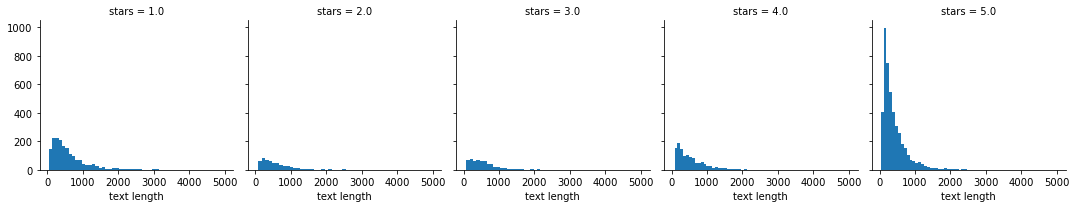

In [7]:
g = sns.FacetGrid(data=yelp_reviews_FL, col='stars')
g.map(plt.hist, 'text length', bins=50)

In [8]:
# Data Pre Processing
# 1. Remove Stop Words
# 2. Stem
# 3. Tokenize

# create a dataset without 3 stars since those are neutral
yelp_data = yelp_reviews_FL[(yelp_reviews_FL['stars'] > 3) | (yelp_reviews_FL['stars'] < 3)]

X = pd.DataFrame(yelp_data['text'])
y = pd.DataFrame(yelp_data['stars'])

In [9]:
#1 Remove stop words
def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

X['text'] = X['text'].apply(process_text)
X

,text
2,"[Danielle, great, job, listened, cut, hair, wa..."
4,"[Ordered, pork, fried, rice, beef, chow, mei, ..."
7,"[Food, good, love, Cuban, sandwiche, place, cl..."
8,"[called, location, multiple, times, throughout..."
12,"[Excellent, stopped, late, lunch, happy, food,..."
...,...
26315,"[Pretty, disappointed, place, Nice, decor, amb..."
26320,"[Ok, place, nice, crowd, servers, poor, commun..."
26322,"[Better, food, Decent, world, shaking, beer, o..."
26323,"[Great, food, Great, service, Two, things, mak..."


In [10]:
# 2 Stem
from nltk.stem.snowball import SnowballStemmer
snowBallStemmer = SnowballStemmer("english")
X['stemmed'] = X['text'].apply(lambda x: [snowBallStemmer.stem(y) for y in x])
X = X.drop(columns=['text'])
X

,stemmed
2,"[daniell, great, job, listen, cut, hair, way, ..."
4,"[order, pork, fri, rice, beef, chow, mei, fun,..."
7,"[food, good, love, cuban, sandwich, place, cle..."
8,"[call, locat, multipl, time, throughout, day, ..."
12,"[excel, stop, late, lunch, happi, food, servic..."
...,...
26315,"[pretti, disappoint, place, nice, decor, ambia..."
26320,"[ok, place, nice, crowd, server, poor, communi..."
26322,"[better, food, decent, world, shake, beer, opt..."
26323,"[great, food, great, servic, two, thing, make,..."


In [12]:
# 3. Tokenize data to turn words into integers for modeling
cv = CountVectorizer() 
X['stemmed']=[" ".join(review) for review in X['stemmed'].values]
X_cv = cv.fit_transform(X['stemmed'])

<BarContainer object of 10 artists>

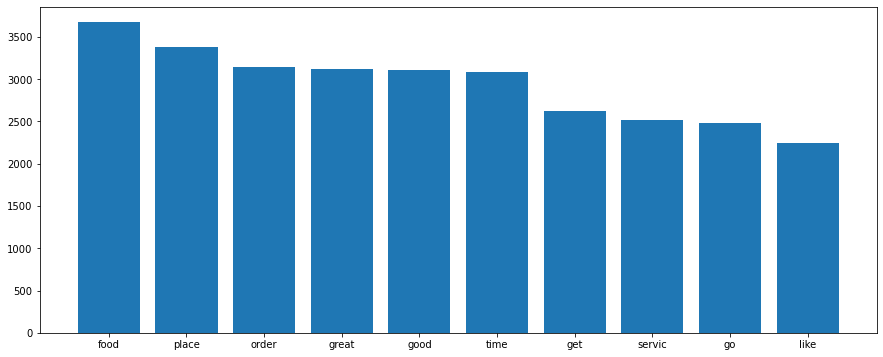

In [39]:
# frequency (bigram would be nice to have) 
chart_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())
chart_freq = pd.DataFrame(chart_df.sum(axis=0)).reset_index()
chart_freq.columns = ['word', 'frequency']
chart_freq = chart_freq.sort_values(by='frequency', ascending=False).head(10)
plt.bar(chart_freq['word'],chart_freq['frequency'])

<AxesSubplot:ylabel='stars'>

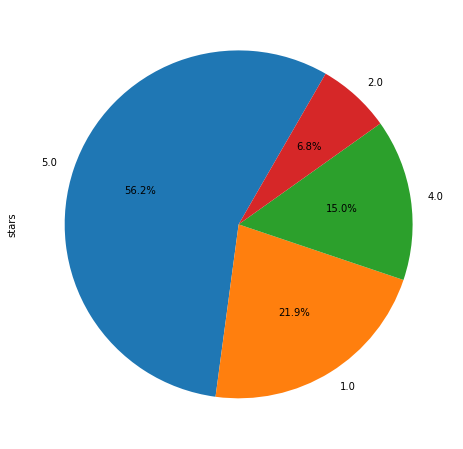

In [15]:
# pie chart of stars for FL restaurants
plt.figure(figsize=(8,8))
y['stars'].value_counts().plot.pie(autopct='%1.1f%%', startangle=60)

C:\Users\mcdc9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


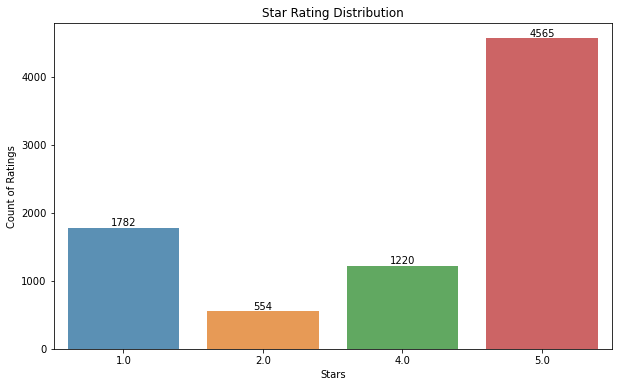

In [16]:
#frequency of star ratings
x=y['stars'].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('Count of Ratings')
plt.xlabel('Stars')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
plt.show();

In [17]:
X_cv
print('Shape of Sparse Matrix: ', X_cv.shape)
print('Amount of Non-Zero Occurrences: ', X_cv.nnz)
# % non-zero values
density = (100.0 * X_cv.nnz / (X_cv.shape[0] * X_cv.shape[1]))
print("Density: {}".format((density)))

Shape of Sparse Matrix:  (8121, 17128)
Amount of Non-Zero occurrences:  319237
Density: 0.22950759188111206


In [41]:
# set up nb model and run predictions
X_train, X_test, y_train, y_test = train_test_split(X_cv, y,test_size=0.3,random_state=101)
nb = MultinomialNB()
nb.fit(X_train,y_train)

predictions = nb.predict(X_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[ 438   18   34   43]
 [  80    3   35   45]
 [  22    1   79  263]
 [  85    2   60 1229]]


              precision    recall  f1-score   support

         1.0       0.70      0.82      0.76       533
         2.0       0.12      0.02      0.03       163
         4.0       0.38      0.22      0.28       365
         5.0       0.78      0.89      0.83      1376

    accuracy                           0.72      2437
   macro avg       0.50      0.49      0.47      2437
weighted avg       0.66      0.72      0.68      2437



C:\Users\mcdc9\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
#nb performance
#%pylab inline 
#pylab.rcParams['figure.figsize'] = (15,6)
##plt.plot(predictions[:20],label = 'Predicted')
#plt.plot(y_test.values[:20], label = 'Actual')
#plt.scatter(predictions[:], y_test.values[:])
#plt.legend()
#plt.show()

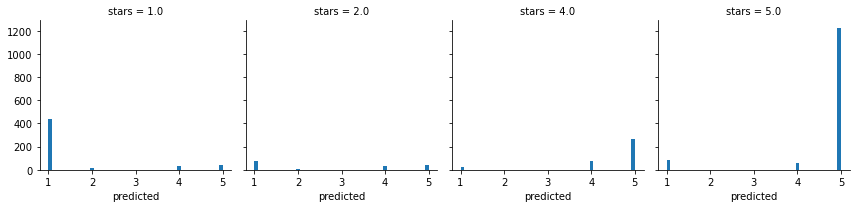

In [43]:
#nb bar chart of predicted and actual
#results['results'] = df(y_test['stars'])
results = y_test.filter(['stars'], axis=1)
results['predicted'] = predictions.tolist()
g = sns.FacetGrid(data=results, col='stars')
g.map(plt.hist, 'predicted', bins=50)

In [44]:
#linear regression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)
print(classification_report(predictions,y_test))

C:\Users\mcdc9\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         1.0       0.79      0.76      0.77       556
         2.0       0.21      0.29      0.24       119
         4.0       0.35      0.43      0.38       296
         5.0       0.88      0.83      0.85      1466

    accuracy                           0.74      2437
   macro avg       0.56      0.57      0.56      2437
weighted avg       0.76      0.74      0.75      2437



C:\Users\mcdc9\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Populating the interactive namespace from numpy and matplotlib


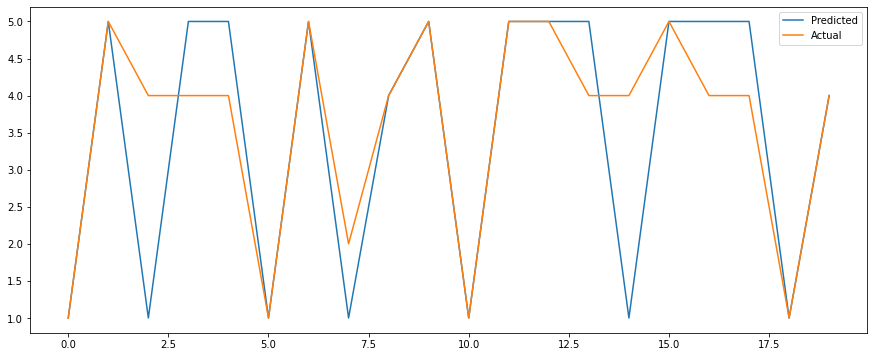

In [45]:
#linear regression performance
%pylab inline 
pylab.rcParams['figure.figsize'] = (15,6)
plt.plot(predictions[:20],label = 'Predicted')
plt.plot(y_test.values[:20], label = 'Actual')
plt.legend()
plt.show()

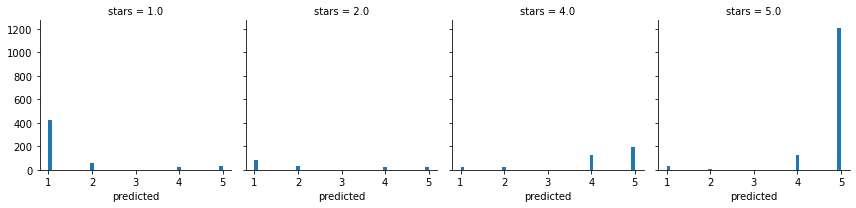

In [46]:
#linear regression bar chart of predicted and actual
results = y_test
results['predicted'] = predictions.tolist()
g = sns.FacetGrid(data=results, col='stars')
g.map(plt.hist, 'predicted', bins=50)

In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Instantiate
sid = SentimentIntensityAnalyzer()
# Generate sentiment scores
sentiment_scores = X['stemmed'].apply(sid.polarity_scores)
sentiment = sentiment_scores.apply(lambda x: x['compound']) # Get compound score
sentiment_scores

2        {'neg': 0.062, 'neu': 0.592, 'pos': 0.346, 'co...
4        {'neg': 0.0, 'neu': 0.852, 'pos': 0.148, 'comp...
7        {'neg': 0.0, 'neu': 0.314, 'pos': 0.686, 'comp...
8        {'neg': 0.014, 'neu': 0.959, 'pos': 0.027, 'co...
12       {'neg': 0.051, 'neu': 0.463, 'pos': 0.486, 'co...
                               ...                        
26315    {'neg': 0.138, 'neu': 0.64, 'pos': 0.222, 'com...
26320    {'neg': 0.117, 'neu': 0.415, 'pos': 0.468, 'co...
26322    {'neg': 0.07, 'neu': 0.453, 'pos': 0.477, 'com...
26323    {'neg': 0.0, 'neu': 0.512, 'pos': 0.488, 'comp...
26327    {'neg': 0.025, 'neu': 0.704, 'pos': 0.272, 'co...
Name: stemmed, Length: 8121, dtype: object

In [26]:
#type(sentiment_scores)
#sentiment_scores.values[1]
#df = X['stemmed']
#results['neu'] = predictions.tolist()
#df['reviews'] = yelp_reviews_FL['stars']
